In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import numpy as np
import ale_py
import random
import time
from envs.ale_utils import setup_training_dir

In [2]:
env = gym.make("ALE/Pong-v5")

In [3]:
action_map = {
    0 : 0, # NOOP
    1 : 2, # RIGHT
    2 : 3 # LEFT
}

In [6]:
# from utils import generate_evaluation_states
# ev_states = generate_evaluation_states(env, device, 100)
# torch.save(ev_states, "ev_states.pt")

In [ ]:
# Resume training of start from scratch
resume_training = True
version = "v1"
checkpoint = f"training/dqn/{version}/training3/1250.pth"
training_number = setup_training_dir(resume_training, "dqn", version)

max_training_time = 7 #h

In [ ]:
from agents.dqn import QNetwork, ReplayBuffer, Update_Q

device = 'cpu'

Q = QNetwork(input_dim = 10, output_dim = 3).to(device)
Q_target = QNetwork(input_dim = 10, output_dim = 3).to(device)
Q_target.load_state_dict(Q.state_dict())
Q_optimizer = torch.optim.Adam(Q.parameters(), lr = 0.0001)
Buffer   = ReplayBuffer()

ev_states = torch.load("ev_states/pong_ev_states.pt")

# Hyperparameters
gamma = 0.99
epsilon = 1
epsilon_min = 0.1
epsilon_decay = 0.000005
batch_size = 32
max_episode = 2000
max_time_steps = 10000
update_frequency = 1
target_update_frequency = 2000
checkpoint_frequency = 50
ever_won = False

In [ ]:
from agents.dqn import load_checkpoint

if resume_training:
    training_vars = load_checkpoint(Q, Q_optimizer, Buffer, checkpoint)
    Q_target.load_state_dict(Q.state_dict())
    returns, avg_Qvalues, td_losses, episode_start, epsilon = training_vars
else:
    episode_start = 0
    returns = []
    avg_Qvalues = []
    td_losses = []

In [ ]:
from agents.dqn import save_checkpoint
from envs.pong_utils import get_avg_Qvalues, get_state, generate_video

start_time = time.time()
tot_training_steps = 0
ball_position = (0, np.array([0, 0]))

for episode in range(episode_start, max_episode):

    total_reward = 0
    points_scored = 0

    # Skip first frame (different color)
    frame, _ = env.reset()
    _ = env.step(0)

    frame, reward, terminated, truncated, info = env.step(0)
    ball_position, player_position, state = get_state(frame, ball_position)
    state = torch.tensor(state).float().to(device)

    for t in range(max_time_steps):

        with torch.no_grad():
            # Decaying epsilon
            epsilon = max(epsilon_min, epsilon - epsilon_decay)
            # epsilon-greedy action selection
            if random.random() < epsilon:
                action = np.random.choice(list(action_map.keys()))
            else:
                action = torch.argmax(Q(state)).item()

        frame, reward, terminated, truncated, info = env.step(action_map[action])

        ball_position, player_position, next_state = get_state(frame, ball_position, player_position)
        next_state = torch.tensor(next_state).float().to(device)

        total_reward += reward
        if reward == 1 : points_scored += 1

        Buffer.put([state, int(action), reward, next_state, terminated, truncated])

        if Buffer.size() > 1000 and t % update_frequency == 0:
            td_loss = Update_Q(Buffer, Q, Q_target, Q_optimizer, batch_size, gamma)
            td_losses.append(td_loss)

        tot_training_steps += 1
        if tot_training_steps % target_update_frequency == 0:
            Q_target.load_state_dict(Q.state_dict())

        if terminated or truncated:
                break

        state = next_state

    # print('episode: {}, reward: {:.1f}'.format(episode, total_reward))
    returns.append(total_reward)
    avg_Qvalues.append(get_avg_Qvalues(Q, ev_states))

    if (episode + 1) % 30 == 0:
        print(f"{episode+1} episodes done. Average reward on last 30 ep. : {np.mean(returns[-30:])}")

    if points_scored == 21 and not ever_won:
        ever_won = True
        print(f"First win ! (Episode {episode})")

    # Training checkpoint
    if (episode + 1) % checkpoint_frequency == 0:
        save_checkpoint(Q, Q_optimizer, Buffer, returns, avg_Qvalues, td_losses, episode, epsilon, f"training/dqn/{version}/training{training_number}/{episode+1}.pth")
        generate_video(env, Q, device, epsilon=0, n_episodes=1, filename=f"training/dqn/{version}/training{training_number}/{episode+1}.mp4")

    if time.time() - start_time > 3600 * max_training_time:
        print(f"Maximum training time of {max_training_time}h exceeded. Interrupting training after {episode} episodes.")
        break

env.close()

First win ! (Episode 1250)
1260 episodes done. Average reward on last 30 ep. : 1.3333333333333333
1290 episodes done. Average reward on last 30 ep. : -0.4
1320 episodes done. Average reward on last 30 ep. : -0.3333333333333333
1350 episodes done. Average reward on last 30 ep. : 0.9666666666666667
1380 episodes done. Average reward on last 30 ep. : -0.43333333333333335
1410 episodes done. Average reward on last 30 ep. : -1.4333333333333333
1440 episodes done. Average reward on last 30 ep. : 0.0
1470 episodes done. Average reward on last 30 ep. : -0.1
1500 episodes done. Average reward on last 30 ep. : 0.7333333333333333
1530 episodes done. Average reward on last 30 ep. : 1.4
1560 episodes done. Average reward on last 30 ep. : 1.1
1590 episodes done. Average reward on last 30 ep. : 0.3333333333333333
1620 episodes done. Average reward on last 30 ep. : 3.5
1650 episodes done. Average reward on last 30 ep. : 1.6666666666666667
1680 episodes done. Average reward on last 30 ep. : 2.5
1710 ep

Text(0, 0.5, 'Average Return')

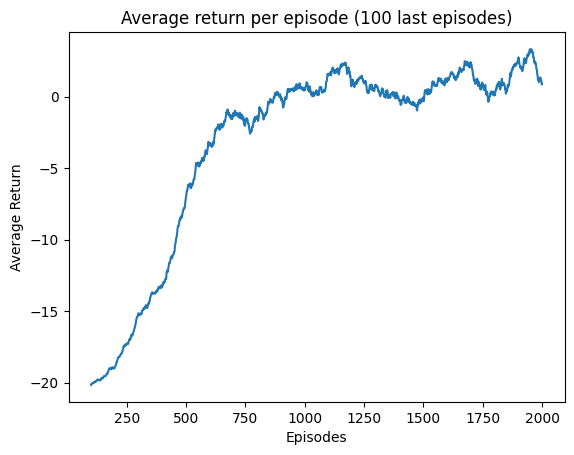

In [12]:
avg_returns = [np.mean(returns[i-100:i]) for i in range(100, len(returns))]
plt.plot(range(100, len(returns)), avg_returns)
plt.title("Average return per episode (100 last episodes)")
plt.xlabel("Episodes")
plt.ylabel("Average Return")

Text(0, 0.5, 'Average Q_value')

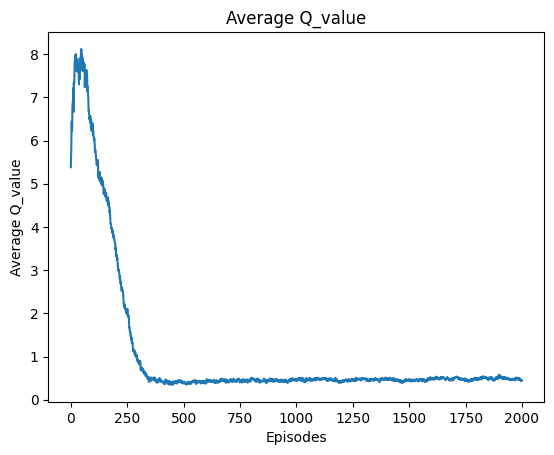

In [13]:
plt.plot(range(len(avg_Qvalues)), avg_Qvalues)
plt.title("Average Q_value")
plt.xlabel("Episodes")
plt.ylabel("Average Q_value")

Text(0, 0.5, 'TD Loss')

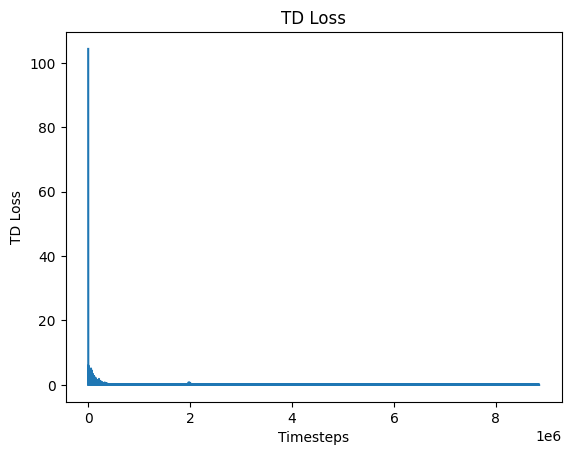

In [14]:
plt.plot(range(len(td_losses)), td_losses)
plt.title("TD Loss")
plt.xlabel("Timesteps")
plt.ylabel("TD Loss")

## 2. Evaluation

In [ ]:
from envs.pong_utils import evaluate_average_return

av_return, victory_rate = evaluate_average_return(Q, env, device, 50, action_map)
print("Results of evaluation on 50 episodes :")
print(f"Average return : {av_return:.2f}")
print(f"Victory rate : {victory_rate:.2f}")

Results of evaluation on 50 episodes :
Average return : 16.44
Victory rate : 1.00


In [47]:
checkpoint_files = [f"training/dqn/{version}/training{training_number}/{i}.pth" for i in range(50, 2050, 50)]

In [ ]:
_ = load_checkpoint(Q, Q_optimizer, Buffer, checkpoint_files[-1])

In [ ]:
generate_video(env, Q, device, 0, 1, "1.mp4")

In [ ]:
# av_returns, victory_rates = [], []

# for checkpoint in checkpoint_files:
#     print(f"Opening {checkpoint}")
#     load_checkpoint(Q, Q_optimizer, Buffer, checkpoint)
#     av_return, victory_rate = evaluate_average_return(Q, env, device, 10, action_map)
#     av_returns.append(av_return)
#     victory_rates.append(victory_rate)

Opening training/dqn/v1/training3/50.pth
Opening training/dqn/v1/training3/100.pth
Opening training/dqn/v1/training3/150.pth
Opening training/dqn/v1/training3/200.pth
Opening training/dqn/v1/training3/250.pth
Opening training/dqn/v1/training3/300.pth
Opening training/dqn/v1/training3/350.pth
Opening training/dqn/v1/training3/400.pth
Opening training/dqn/v1/training3/450.pth
Opening training/dqn/v1/training3/500.pth
Opening training/dqn/v1/training3/550.pth
Opening training/dqn/v1/training3/600.pth
Opening training/dqn/v1/training3/650.pth
Opening training/dqn/v1/training3/700.pth
Opening training/dqn/v1/training3/750.pth
Opening training/dqn/v1/training3/800.pth
Opening training/dqn/v1/training3/850.pth
Opening training/dqn/v1/training3/900.pth
Opening training/dqn/v1/training3/950.pth
Opening training/dqn/v1/training3/1000.pth
Opening training/dqn/v1/training3/1050.pth
Opening training/dqn/v1/training3/1100.pth
Opening training/dqn/v1/training3/1150.pth
Opening training/dqn/v1/trainin

Text(0, 0.5, 'Return')

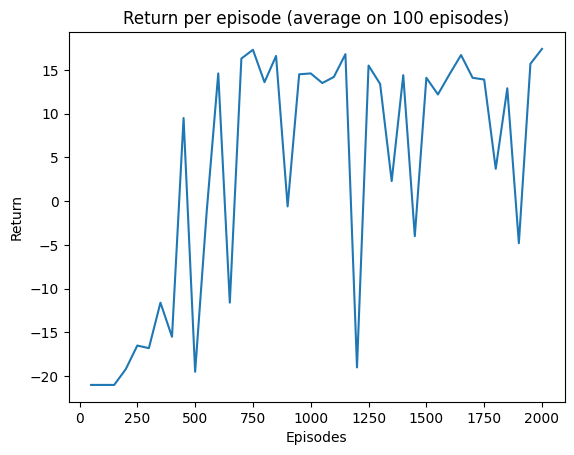

In [ ]:
# plt.plot(range(50, 2050, 50), av_returns)
# plt.title("Return per episode (average on 100 episodes)")
# plt.xlabel("Episodes")
# plt.ylabel("Return")

Text(0, 0.5, 'Victory rate')

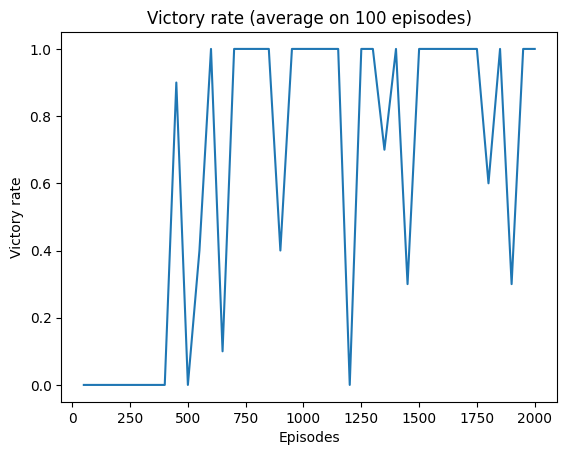

In [ ]:
# plt.plot(range(50, 2050, 50), victory_rates)
# plt.title("Victory rate (average on 100 episodes)")
# plt.xlabel("Episodes")
# plt.ylabel("Victory rate")